In [306]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
# This command ensures the plots are plotted just below the code that generates them
%matplotlib inline

# Training Neural Network From Scratch

In this project we will construct a neural network without using any external libraries to understand what is going undet the hood. We will follow the following order:

## Step 1: Understand the math | Calculus

We will understand how we can use calculus to quantify how sensitive a function is relative to the change in its input. Simply put if change the input by a small amount how much does and in what direction does the function change.

## Step 2: Back Propogation & Forward Pass

We will use a computational graph to run forward pass and then run backpropation and interpret the multiplication and addition gates in the computational graph. We will run the forward and back prop on a single neuron.

## Step 3: Two Layer Multilayer Perceptron

We will create a two layer multilayer perceptron using the hyperolic tangent non-linearity tanh and train it on a L2 loss function using gradient descent.

# Step 1: The math | Calculus

Let f(x) be a function of x. The derivative of f(x) with respect to x tell us how sensitive it is to x, in other words if we change x slightly how much does the output changes. Lets look at an example of the following quadratic function which we will perturb by a small amount h. $$x^2 + 2x + 4$$
Derivatives can be applied to functions with multiple inputs as well.


The value of the function at x = 3 is 19 units
The value of the function at x + h = 3.0001 is 19.000800010000003 units

The derivative of the function is 8.000100000025157 which means that if you perturb x by 1 unit you will change the response by 1 x 8 = 8 units



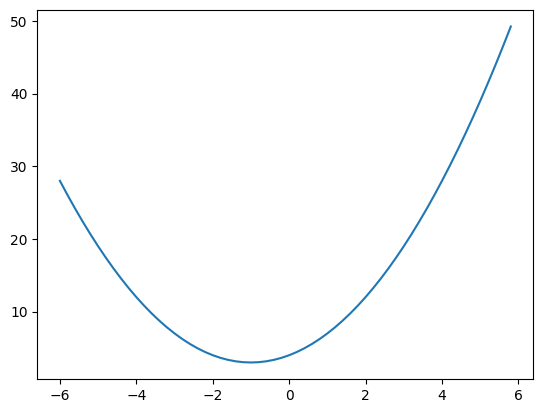

In [307]:
def func(x):
  return x**2 + 2*x + 4

h = 0.0001
x = 3
print(f"The value of the function at x = 3 is {func(x)} units")
print(f"The value of the function at x + h = 3.0001 is {func(x+h)} units")
#defination of derivative
der = (func(x+h) - func(x)) / h
print(f"\nThe derivative of the function is {der} which means that if you perturb x by 1 unit you will change the response by 1 x 8 = 8 units\n")

# Lets plot our function for visualization
xs = np.arange(-6,6,0.2)
ys = func(xs)
plt.plot(xs,ys)


#Step 2: Back Propogation & Forward Pass
You can analytically find the derivative of any expression using the limit defination of the derivative. But when working with neural networks (NN) finding the analytical derivative is extrememly laborious. This problem is solved by transforming the function into a computational graph and then solving the derivatives of smaller nodes recursively. This is called Back Propogation and it is at the core of how NN models learn.

## Forward Pass
This is simply evaluating our functions on some values

## Back Propogation
This the recursive step of evaluting derivative using the chain rule.

In [309]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad # using += becasuse of the bug
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)),
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


#Computational Graph
We will use the graphviz API to visualize our computational graph

In [310]:
from graphviz import Digraph

def trace(root):

  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Forward Pass

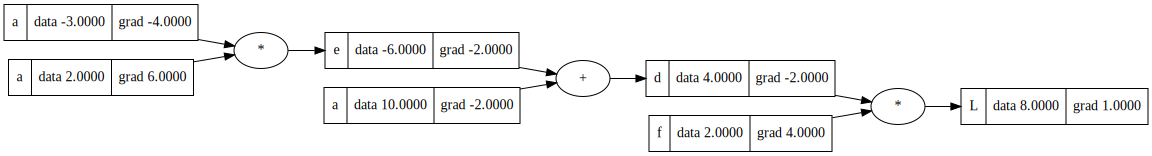

In [311]:
# Visualize the forward pass for L
draw_dot(L)

## Back Propogation

In back propgation when we break up a function in its atomic level by just using
"+" and "*". Addition has an interpretation of just distributing a the derivative and the multiplication has an interpretation of switching and scaling the derivative.

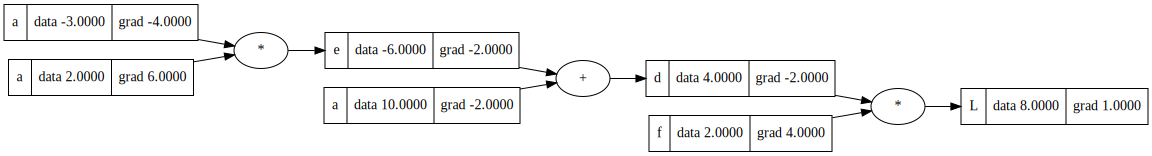

In [312]:
# Manual Backprop

L.grad = 1.0 # manually encoding dL/dL = 1
f.grad = 4.0*1.0
d.grad = -2.0*1.0
c.grad = -2
e.grad = -2
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)

## Back Propogation on a single Neruron
We will use the tanh as our activation function. Tanh has a good property of being 0 mean.

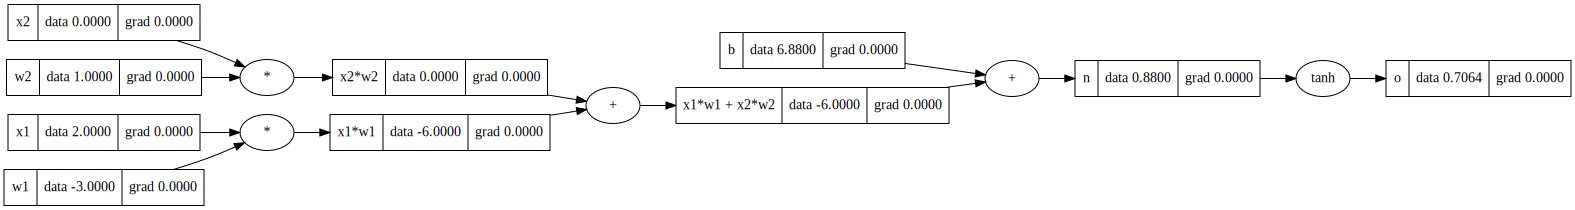

In [313]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias
b = Value(6.88, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o) # This will graph the forward pass



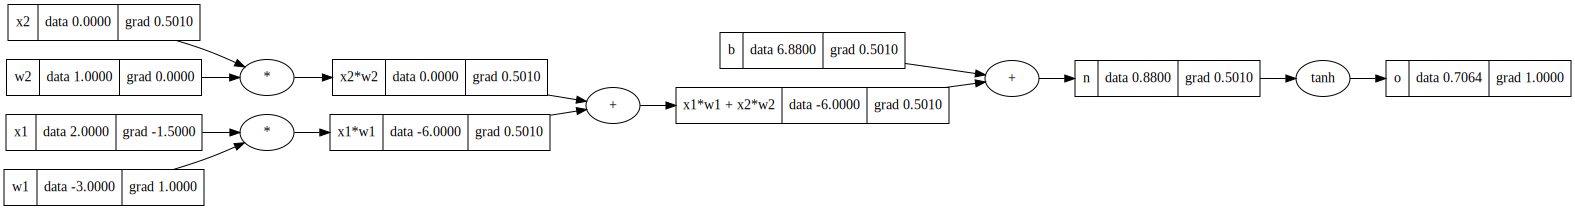

In [314]:
## MANUAL BACKPROP

o.grad = 1.0
n.grad = 0.501
b.grad = 0.501
x1w1x2w2.grad = 0.501
x2w2.grad = 0.501
x1w1.grad = 0.501
x2.grad = 0.501
w2.grad = 0
x1.grad = -1.5
w1.grad = 1.0
draw_dot(o)



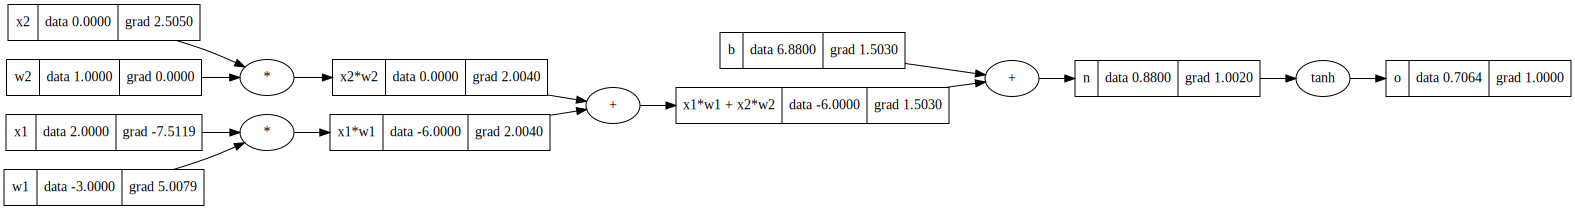

In [315]:
## AUTOMATIC BACKPROP
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o) # This will be the back propogation :)



To avoid calling the ._backward again and again we will use a topoloical sort.
This will alow us to create a sequence of nodes that will respect theie dependencies. The topological sort is implemented in the class under the backward function.

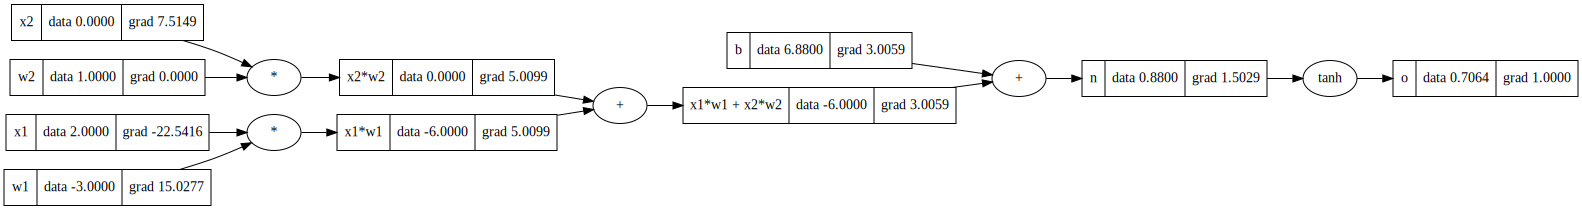

In [316]:
## AUTOMATIC BACKPROP WITHOUT CALLING _backward EVERYTIME
o.backward()
draw_dot(o)

## Two Layer Multilayer Perceptron

In [317]:
import torch

In [318]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


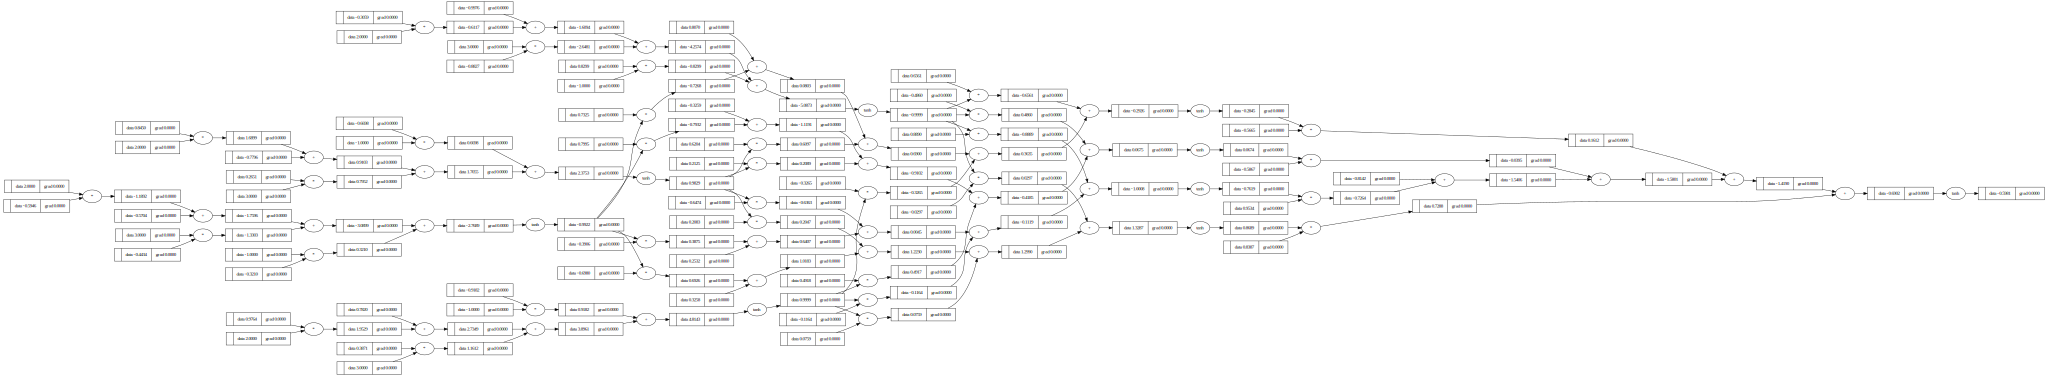

In [321]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

## Loss Function

A loss function measure the performance of the neural network. We will implement a simple L2 loss function.  